In [3]:
import tensorflow as tf
from tensorflow.contrib.slim import nets
slim = tf.contrib.slim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## Build Resnet50 v1 network
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3], name="inputs")
with slim.arg_scope(nets.resnet_v1.resnet_arg_scope()):
    net, endpoints = nets.resnet_v1.resnet_v1_50(inputs, num_classes=None, is_training=False)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
## Start Session and load pretrained Model
sess = tf.InteractiveSession()
pretrain_model = './resnet_v1_50.ckpt'
variable_to_restore = slim.get_variables_to_restore()
init_fn = slim.assign_from_checkpoint_fn(pretrain_model, variable_to_restore, ignore_missing_vars=True)
init_fn(sess)

INFO:tensorflow:Restoring parameters from ./resnet_v1_50.ckpt


In [4]:
## show conv varibale
variable_names = [v.name for v in tf.trainable_variables()]
for i in range(len(variable_names)):
    print(variable_names[i])

resnet_v1_50/conv1/weights:0
resnet_v1_50/conv1/BatchNorm/gamma:0
resnet_v1_50/conv1/BatchNorm/beta:0
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/weights:0
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/gamma:0
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/beta:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/weights:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/gamma:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/beta:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/weights:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/BatchNorm/gamma:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/BatchNorm/beta:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/weights:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/BatchNorm/gamma:0
resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/BatchNorm/beta:0
resnet_v1_50/block1/unit_2/bottleneck_v1/conv1/weights:0
resnet_v1_50/block1/unit_2/bottleneck_v1/conv1/BatchNorm/gamma:0
resnet_v1_50/block1/uni

In [5]:
endpoints

OrderedDict([('resnet_v1_50/conv1',
              <tf.Tensor 'resnet_v1_50/conv1/Relu:0' shape=(?, 112, 112, 64) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/FusedBatchNorm:0' shape=(?, 56, 56, 256) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/conv1',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/Relu:0' shape=(?, 56, 56, 64) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/conv2',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/Relu:0' shape=(?, 56, 56, 64) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1/conv3',
              <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/BatchNorm/FusedBatchNorm:0' shape=(?, 56, 56, 256) dtype=float32>),
             ('resnet_v1_50/block1/unit_1/bottleneck_v1',
              <tf.Tensor 're

# Show First Convolutional Kernel by Direct Mapping

In [6]:
# show firsr conv layer 
conv1 = sess.run("resnet_v1_50/conv1/weights:0")
print("conv1 shape: ", conv1.shape)

conv1 shape:  (7, 7, 3, 64)


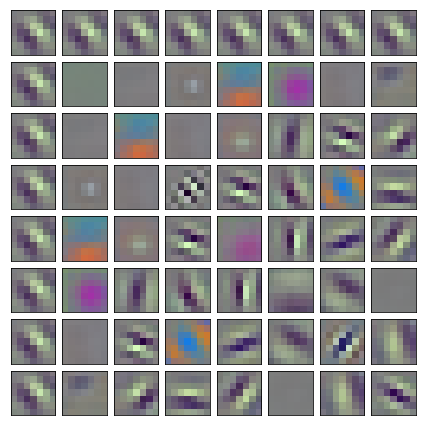

In [7]:
x_min = np.min(conv1)
x_max = np.max(conv1)
kernel_0_to_1 = (conv1 - x_min) / (x_max - x_min)

rows = 8
cols = 8
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 6))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(kernel_0_to_1[:,:,:,i*j])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].axis('image')
plt.tight_layout(pad=1, h_pad=0, w_pad=0)
plt.show()

# Show Convolutional Kernel by Activation Maximination

In [4]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [64]:
## show filter_index kernel to visualize
def tf_generate_pattern(sess, layer_output, filter_index, iter_num=40):
    input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128.
    loss = tf.reduce_mean(layer_output[:, :, :, filter_index])
    grads = tf.gradients(loss, inputs)[0]
    grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    
    step = 1.
    for i in range(iter_num):
        loss_value, grads_value = sess.run([loss, grads], feed_dict={inputs:input_img_data})
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

In [67]:
image = tf_generate_pattern(sess, endpoints['resnet_v1_50/block2/unit_1/bottleneck_v1'], 10)

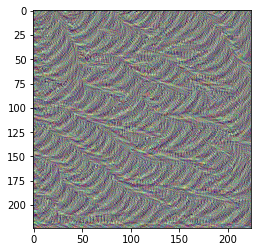

In [68]:
plt.imshow(image)
plt.show()

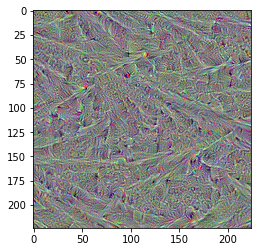

In [75]:
image = tf_generate_pattern(sess, endpoints['resnet_v1_50/block4/unit_1/bottleneck_v1'], 510,50)
plt.imshow(image)
plt.show()

In [2]:
## Build Resnet50 v1 network
inputs = tf.placeholder(tf.float32, [None, 28, 28, 3], name="inputs")
with slim.arg_scope(nets.resnet_v1.resnet_arg_scope()):
    net, endpoints = nets.resnet_v1.resnet_v1_50(inputs, num_classes=None, is_training=False)
## Start Session and load pretrained Model
sess = tf.InteractiveSession()
pretrain_model = './resnet_v1_50.ckpt'
variable_to_restore = slim.get_variables_to_restore()
init_fn = slim.assign_from_checkpoint_fn(pretrain_model, variable_to_restore, ignore_missing_vars=True)
init_fn(sess)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from ./resnet_v1_50.ckpt


In [3]:
## show filter_index kernel to visualize
def tf_generate_pattern(sess, layer_output, filter_index, iter_num=40):
    input_img_data = np.random.random((1, 28, 28, 3)) * 20 + 128.
    loss = tf.reduce_mean(layer_output[:, :, :, filter_index])
    grads = tf.gradients(loss, inputs)[0]
    grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    
    step = 1.
    for i in range(iter_num):
        loss_value, grads_value = sess.run([loss, grads], feed_dict={inputs:input_img_data})
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

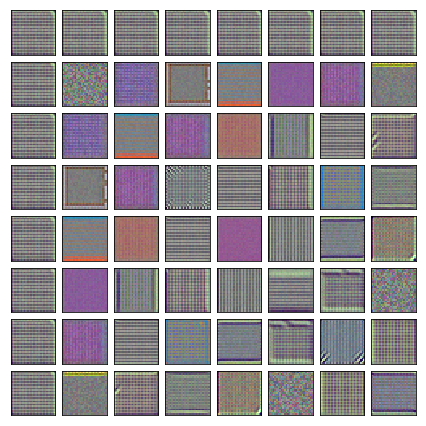

In [7]:
rows = 8
cols = 8
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 6))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(tf_generate_pattern(sess, endpoints['resnet_v1_50/conv1'],i*j, 40))
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].axis('image')
plt.tight_layout(pad=1, h_pad=0, w_pad=0)
plt.show()

conv1 shape:  (7, 7, 3, 64)


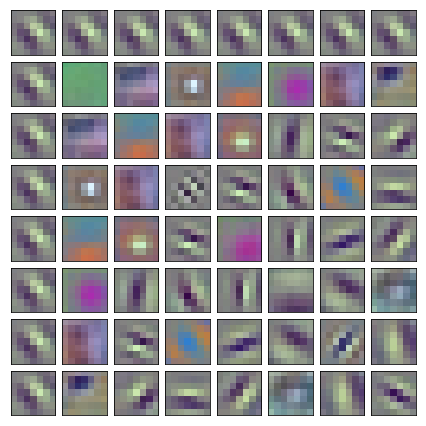

In [9]:
# show firsr conv layer 
conv1 = sess.run("resnet_v1_50/conv1/weights:0")
print("conv1 shape: ", conv1.shape)


rows = 8
cols = 8
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 6))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(Image.fromarray(deprocess_image(conv1[:,:,:,i*j])).resize([28,28]))
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].axis('image')
plt.tight_layout(pad=1, h_pad=0, w_pad=0)
plt.show()

In [5]:
## Build Resnet50 v1 network
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3], name="inputs")
with slim.arg_scope(nets.resnet_v1.resnet_arg_scope()):
    net, endpoints = nets.resnet_v1.resnet_v1_50(inputs, num_classes=None, is_training=False)
## Start Session and load pretrained Model
sess = tf.InteractiveSession()
pretrain_model = './resnet_v1_50.ckpt'
variable_to_restore = slim.get_variables_to_restore()
init_fn = slim.assign_from_checkpoint_fn(pretrain_model, variable_to_restore, ignore_missing_vars=True)
init_fn(sess)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from ./resnet_v1_50.ckpt


In [6]:
## show filter_index kernel to visualize
def tf_generate_pattern(sess, layer_output, filter_index, iter_num=40):
    input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128.
    loss = tf.reduce_mean(layer_output[:, :, :, filter_index])
    grads = tf.gradients(loss, inputs)[0]
    grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    
    step = 1.
    for i in range(iter_num):
        loss_value, grads_value = sess.run([loss, grads], feed_dict={inputs:input_img_data})
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

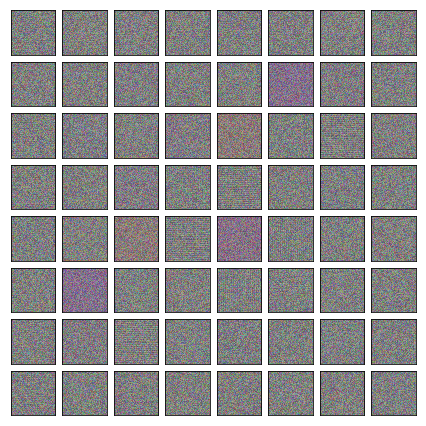

In [7]:
rows = 8
cols = 8
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 6))
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(tf_generate_pattern(sess, endpoints['resnet_v1_50/conv1'],i*j, 40))
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].axis('image')
plt.tight_layout(pad=1, h_pad=0, w_pad=0)
plt.show()